# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [45]:
# import libraries here; add more as necessary
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [2]:
def get_logger(level=logging.WARNING, force_level=False, name='logger'):
    
    logger_levels = [logging.CRITICAL, logging.ERROR, logging.WARNING,
                     logging.INFO, logging.DEBUG]
    
    if level not in logger_levels:
        raise ValueError('Invalid level name. Valid names {}'.format(logger_levels))
    
    formatter = 'UDACITY ARVATO PROJECT: %(asctime)s - %(levelname)s: %(message)s'
    date_format = '%d/%m/%Y %H:%M:%S'
    logging.basicConfig(format=formatter, datefmt=date_format, level=level)

    logger = logging.getLogger(name)
    if logger.getEffectiveLevel() == 0 or force_level:
        logger.setLevel(level)

    return logger


def set_log_level(verbose, debug):
    if verbose:
        get_logger(logging.INFO, force_level=True)
    if debug:
        get_logger(logging.DEBUG, force_level=True)


In [3]:
class Timer:
    
    def __init__(self, decimal_round=5):
        self.decimal_round = decimal_round

    def start(self):
        self.timer_start = time.perf_counter()
        self.timer_last = self.timer_start

    def lapse(self):
        last_lapse = self.timer_last
        self.timer_last = time.perf_counter()
        return round(self.timer_last - last_lapse, 5) 

    def total(self):
        return round(time.perf_counter() - self.timer_start, 5) 


In [4]:
def print_df_full(data):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    display(data)
    
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.max_colwidth', 50)


def convert_to_numeric(string):
    try: 
        return float(string)
    except ValueError:
        return string


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv(r'./datasets/azdias.csv', index_col='Unnamed: 0')
customers = pd.read_csv(r'./datasets/customers.csv', index_col='Unnamed: 0')

C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
logger = get_logger()
timer = Timer(decimal_round=5)

### 0.1. Check dataset integrity

#### Verify that the datasets are as shown in the above description

In [7]:
print('AZDIAS shape -', azdias.shape)
print('CUSTOMERS shape -', customers.shape)

AZDIAS shape - (891221, 366)
CUSTOMERS shape - (191652, 369)


In [8]:
demographic_columns = azdias.columns
extra_columns = [col for col in customers.columns if col not in demographic_columns]

print('Extra columns:', extra_columns)

Extra columns: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The dimensions and the extra columns, match the description.

In [9]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers[demographic_columns].head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [11]:
customers[extra_columns].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


#### Solving WARNINGS

We can look at the datatypes of columns 18 and 19 since we got a warning while we loaded the data.

In [12]:
warning_columns = azdias.columns[[18, 19]]
print('WARNING columns:', warning_columns)

WARNING columns: Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [13]:
azdias[warning_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 20.4+ MB


In [14]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [15]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description, also there are 'nan' values.

In [16]:
def clean_warning_columns(df, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start cleaning warning columns')
    
    logger.debug('Replacing "X", "XX" and "nan" values with -1')
    replacements = {"X": np.nan, "XX": np.nan}
    df[columns] = df[columns].replace(replacements)
    logger.debug('Replaced columns: {0} in {1} seconds'.format(list(columns), timer.lapse()))
    
    logger.debug('Changing data type to float')
    df[columns] = df[columns].astype(float)
    logger.debug('Changed data type to float in {} seconds'.format(timer.lapse()))
    
    logger.info('End cleaning warning columns in {} seconds'.format(timer.total()))
    return df

In [17]:
azdias = clean_warning_columns(azdias, warning_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:24:33 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 20:24:33 - DEBUG: Replacing "X", "XX" and "nan" values with -1
UDACITY ARVATO PROJECT: 06/05/2021 20:24:33 - DEBUG: Replaced columns: ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] in 0.3829 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:33 - DEBUG: Changing data type to float
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Changed data type to float in 0.24233 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: End cleaning warning columns in 0.626 seconds


In [18]:
customers = clean_warning_columns(customers, warning_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Replacing "X", "XX" and "nan" values with -1
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Replaced columns: ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] in 0.09256 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Changing data type to float
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Changed data type to float in 0.07733 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: End cleaning warning columns in 0.17078 seconds


Check whether the replacement has been carried out properly.

In [19]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [20]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

### 0.2. Explore metadata datasets

Additionally we have been given two excel books.

- DIAS Attributes - Values 2017.xlsx - Has a description of demographic columns, information about range of values each column can take and their respective meanings.Loaded in metadata_values.
- DIAS Information Levels - Attributes 2017.xlsx - Has detailed information about each column with additional notes wherever required. Loaded in metadata_info_levels.

We can use these two dataframes to understand the data.

In [21]:
metadata_values = pd.read_csv(r'./datasets/metadata/metadata_values.txt', sep='\t', encoding='UTF-16')
metadata_info_levels = pd.read_csv(r'./datasets/metadata/metadata_info_levels.txt', sep='\t', encoding='UTF-16')

In [22]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [23]:
metadata_info_levels.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


##### Metadata datasets preprocessing

We can use the ffill() method of pandas, to replace the NaN values of the dataset by the value of the previous row.

In [24]:
metadata_values[['Attribute', 'Description']] = metadata_values[['Attribute', 'Description']].ffill()

In [25]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


##### Described features

We must check how many features are described in the metadata datasets.

In [26]:
metadata_info_levels.drop_duplicates(subset=['Attribute'])

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [27]:
metadata_values.drop_duplicates(subset=['Attribute'])

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


We can see that there are only 313 (in metadata_info_levels dataset) and 314 (in metadata_values dataset) different columns described, but in the AZDIAS dataset, there are 366 demographic columns. We need to check which features have no description in metadata datasets.

In [28]:
metadata_columns = metadata_values.Attribute.unique().tolist()

described_columns = (set(metadata_columns) & set(demographic_columns))
undescribed_columns = (set(metadata_columns) - set(demographic_columns))

print("Number of described demographic columns: ", len(described_columns))
print("Number of undescribed demographic columns: ", len(undescribed_columns))

Number of described demographic columns:  272
Number of undescribed demographic columns:  42


In [29]:
print_df_full(metadata_values[['Attribute', 'Description']].drop_duplicates(subset=['Attribute']))

,Attribute,Description
0,AGER_TYP,best-ager typology
5,ALTERSKATEGORIE_GROB,age classification through prename analysis
11,ALTER_HH,main age within the household
33,ANREDE_KZ,gender
36,ANZ_HAUSHALTE_AKTIV,number of households in the building
37,ANZ_HH_TITEL,number of academic title holder in building
38,ANZ_PERSONEN,number of adult persons in the household
39,ANZ_TITEL,number of professional title holder in household
40,BALLRAUM,distance to next urban centre
48,BIP_FLAG,business-flag indicating companies in the building


### 0.3. Data Preprocessing

##### Nulls normalization

In [30]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


Looking at the metadata of the columns in the provided excel workbooks, it can be seen that some columns have their own category to indicate a null value (for example categories like 'unknown', 'unknown / no main age detectable', 'numeric value', etc..). We could to unify the null values and replace these categories with np.nan values. Will only be done for the 272 columns that are described in the metadata datasets, as for the remaining 42 columns, we do not know the meaning of the values.

In [31]:
def get_unkown_values_data(metadata, unkown_categories, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start getting unkown categories from metadata')
    
    unknown_values = metadata[metadata['Meaning'].isin(unkown_categories)]
    unknown_values = unknown_values.reset_index(drop=True)
    logger.debug('Number of features with unknown categories:'.format(len(unknown_values)))
    
    logger.info('End getting unkown categories from metadata in {} seconds'.format(timer.total()))
    return unknown_values


In [32]:
unknown_values = ['unknown', 'unknown / no main age detectable', 'numeric value', 'none']

unknown_data = get_unkown_values_data(metadata_values, unknown_values, verbose=True, debug=True)
print_df_full(unknown_data)

UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: End getting unkown categories from metadata in 0.0031 seconds


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,BALLRAUM,distance to next urban centre,-1,unknown
5,BIP_FLAG,business-flag indicating companies in the building,-1,unknown
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
7,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typology,-1,unknown
8,CJT_GESAMTTYP,customer journey typology,0,unknown
9,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


In [33]:
def replace_unknown_values(data, metadata, unknown_values, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    unknown_data = get_unkown_values_data(metadata, unknown_values, verbose=verbose, debug=debug)
    
    logger.info('Start replacing unkown values')
    
    for attribute in unknown_data['Attribute']:
        
        if attribute in data.columns:
            unknown_categories = _get_categories(unknown_data, attribute)
            data[attribute] = data[attribute].apply(lambda x: np.nan if x in unknown_categories[attribute] else x)
            
            logger.debug('Replaced {0} to NaN in {1} column in {2} seconds'.format(
                unknown_categories[attribute], attribute, timer.lapse()))
        else:
            logger.debug('Attribute {} not in data'.format(attribute))
    
    logger.info('End replacing unkown values in {} seconds'.format(timer.total()))
    return data


def _get_categories(data, attribute):
    output = {}
    for attribute in data['Attribute']:
        categories = data[data['Attribute'] == attribute]['Value']
        categories = categories.astype(str).str.cat(sep=', ')
        categories = [str(x).strip() for x in categories.split(', ')]

        output[attribute] = [convert_to_numeric(x) for x in categories]
    return output


In [34]:
azdias = replace_unknown_values(azdias, metadata_values, unknown_values, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: End getting unkown categories from metadata in 0.00333 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:34 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 20:24:35 - DEBUG: Replaced [-1.0] to NaN in AGER_TYP column in 1.0893 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in ALTERSKATEGORIE_GROB column in 0.62222 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:36 - DEBUG: Replaced [0.0] to NaN in ALTER_HH column in 0.51703 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:37 - DEBUG: Replaced [-1.0, 0.0] to NaN in ANREDE_KZ column in 0.62505 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:24:38 - DEBUG: Replaced [-1.0] to NaN in BALLRAUM column in 0.46927 seconds
UDACITY ARVATO PR

UDACITY ARVATO PROJECT: 06/05/2021 20:25:06 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSVAN column in 0.53769 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:06 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSZUL column in 0.50816 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:07 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW1 column in 0.43691 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:07 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW2 column in 0.47744 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:08 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.52465 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:08 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.48129 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:08 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXAH column in 0.43173 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:09 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXBJ column in 0.4332 seconds
UDACITY ARVATO PROJEC

UDACITY ARVATO PROJECT: 06/05/2021 20:25:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2000 column in 0.43467 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:37 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.45439 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:37 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.46352 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:38 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.4919 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:38 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.41485 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:39 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.45177 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:39 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.41799 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:25:40 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2009 column in 0.44033 seconds
UDACITY A

UDACITY ARVATO PROJECT: 06/05/2021 20:26:05 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.43788 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:05 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.44976 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.45113 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.41743 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.46452 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.41372 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_EUROPA column in 0.42585 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:08 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HER

UDACITY ARVATO PROJECT: 06/05/2021 20:26:34 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_120 column in 0.44376 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.44139 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.45027 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.44879 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.4292 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.43854 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:37 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.44772 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:26:37 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MOTOR column in 0.48566 seconds
UDACITY ARVATO P

UDACITY ARVATO PROJECT: 06/05/2021 20:27:04 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.47969 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:05 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.59112 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:05 - DEBUG: Replaced [-1.0, 0.0] to NaN in KKK column in 0.43106 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:06 - DEBUG: Replaced ['…'] to NaN in MIN_GEBAEUDEJAHR column in 0.4363 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:06 - DEBUG: Replaced [6.0] to NaN in MOBI_REGIO column in 0.41673 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:08 - DEBUG: Replaced [-1.0, 0.0] to NaN in NATIONALITAET_KZ column in 1.70079 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:09 - DEBUG: Replaced [0.0] to NaN in ONLINE_AFFINITAET column in 0.8497 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:10 - DEBUG: Replaced [-1.0] to NaN in ORTSGR_KLS9 column in 0.95728 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:10 - DE

In [35]:
customers = replace_unknown_values(customers, metadata_values, unknown_values, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:27:31 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 20:27:31 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 20:27:31 - INFO: End getting unkown categories from metadata in 0.00896 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:31 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 20:27:32 - DEBUG: Replaced [-1.0] to NaN in AGER_TYP column in 0.54418 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:32 - DEBUG: Replaced [-1.0, 0.0] to NaN in ALTERSKATEGORIE_GROB column in 0.28034 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:33 - DEBUG: Replaced [0.0] to NaN in ALTER_HH column in 0.27464 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:33 - DEBUG: Replaced [-1.0, 0.0] to NaN in ANREDE_KZ column in 0.29537 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:33 - DEBUG: Replaced [-1.0] to NaN in BALLRAUM column in 0.26341 seconds
UDACITY ARVATO P

UDACITY ARVATO PROJECT: 06/05/2021 20:27:48 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSVAN column in 0.25674 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:48 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSZUL column in 0.24688 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:49 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW1 column in 0.25394 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:49 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW2 column in 0.27748 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:49 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.25503 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:49 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.27112 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:50 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXAH column in 0.25355 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:27:50 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXBJ column in 0.25618 seconds
UDACITY ARVATO PROJE

UDACITY ARVATO PROJECT: 06/05/2021 20:28:05 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2000 column in 0.30406 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.26198 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.25022 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.25096 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:06 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.24931 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.25932 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.25638 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2009 column in 0.26293 seconds
UDACITY 

UDACITY ARVATO PROJECT: 06/05/2021 20:28:22 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.25709 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:22 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.25457 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.25972 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.25146 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.25676 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.25373 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:24 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_EUROPA column in 0.25568 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:24 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HER

UDACITY ARVATO PROJECT: 06/05/2021 20:28:39 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_120 column in 0.25456 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:39 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.25612 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:39 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.25123 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:40 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.25706 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:40 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.256 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:40 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.27903 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:40 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.2477 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:41 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MOTOR column in 0.25842 seconds
UDACITY ARVATO PRO

UDACITY ARVATO PROJECT: 06/05/2021 20:28:56 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.26099 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:56 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.25058 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:56 - DEBUG: Replaced [-1.0, 0.0] to NaN in KKK column in 0.25357 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:56 - DEBUG: Replaced ['…'] to NaN in MIN_GEBAEUDEJAHR column in 0.25144 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:57 - DEBUG: Replaced [6.0] to NaN in MOBI_REGIO column in 0.24842 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:57 - DEBUG: Replaced [-1.0, 0.0] to NaN in NATIONALITAET_KZ column in 0.36797 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:57 - DEBUG: Replaced [0.0] to NaN in ONLINE_AFFINITAET column in 0.2537 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:57 - DEBUG: Replaced [-1.0] to NaN in ORTSGR_KLS9 column in 0.25482 seconds
UDACITY ARVATO PROJECT: 06/05/2021 20:28:58 - D

### 0.4. Data Univariate Analysis

#### Remove columns with a high percentage of Null values

In [36]:
def get_missing_columns(data, threshold=0.3, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start labelling columns as missing')
    
    data_missing_pctg = _get_missing_percentage_column(data)
    remove_columns = data_missing_pctg['column'][data_missing_pctg['missing_pctg'] > threshold].tolist()
    logger.debug('Columns labelled as missing: {}'.format(remove_columns))
        
    logger.info('End labelling columns as missing in {}'.format(timer.total()))
    return remove_columns
    

def _get_missing_percentage_column(data):
    missing_pctg = data.isna().sum() / len(data)
    
    return pd.DataFrame({'column': data.columns,
                         'missing_pctg': missing_pctg}
                       ).reset_index(drop=True)


In [37]:
# missing columns in AZDIAS
missing_columns_azdias = get_missing_columns(azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:29:08 - INFO: Start labelling columns as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:29:12 - DEBUG: Columns labelled as missing: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_KW3', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'TITEL_KZ']
UDACITY ARVATO PROJECT: 06/05/2021 20:29:12 - INFO: End labelling columns as missing in 4.36079


In [38]:
# missing columns in CUSTOMERS
missing_columns_customers = get_missing_columns(customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:29:12 - INFO: Start labelling columns as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:29:13 - DEBUG: Columns labelled as missing: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_ALTER1', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_HERST1', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KW3', 'KBA05_MOD1', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1800', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_KMH_0_140', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_SE

In [39]:
missing_columns = list(set(missing_columns_azdias) & set(missing_columns_customers))
missing_columns

['KBA05_MOD8',
 'PLZ8_ANTG4',
 'KBA05_SEG9',
 'KBA05_MOTRAD',
 'KBA05_ANHANG',
 'KBA05_BAUMAX',
 'KBA05_SEG6',
 'KBA05_SEG5',
 'ALTER_KIND4',
 'KBA05_SEG1',
 'ALTER_KIND1',
 'EXTSEL992',
 'ALTER_KIND2',
 'KBA05_CCM4',
 'KK_KUNDENTYP',
 'ALTER_KIND3',
 'TITEL_KZ',
 'KBA05_KW3',
 'KBA05_SEG8',
 'AGER_TYP',
 'KBA05_MOD1',
 'ALTER_HH',
 'KBA05_SEG7']

In [40]:
def drop_columns(data, column_list, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing columns')
    
    data = data.drop(column_list, axis=1)
    logger.debug('Removed columns: {}'.format(column_list))
    
    logger.info('End removing columns in {} seconds'.format(timer.total()))
    return data


In [41]:
azdias = drop_columns(azdias, missing_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:29:13 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 20:29:46 - DEBUG: Removed columns: ['KBA05_MOD8', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_MOTRAD', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_SEG6', 'KBA05_SEG5', 'ALTER_KIND4', 'KBA05_SEG1', 'ALTER_KIND1', 'EXTSEL992', 'ALTER_KIND2', 'KBA05_CCM4', 'KK_KUNDENTYP', 'ALTER_KIND3', 'TITEL_KZ', 'KBA05_KW3', 'KBA05_SEG8', 'AGER_TYP', 'KBA05_MOD1', 'ALTER_HH', 'KBA05_SEG7']
UDACITY ARVATO PROJECT: 06/05/2021 20:29:47 - INFO: End removing columns in 33.89365 seconds


In [42]:
customers = drop_columns(customers, missing_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:29:47 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 20:29:50 - DEBUG: Removed columns: ['KBA05_MOD8', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_MOTRAD', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_SEG6', 'KBA05_SEG5', 'ALTER_KIND4', 'KBA05_SEG1', 'ALTER_KIND1', 'EXTSEL992', 'ALTER_KIND2', 'KBA05_CCM4', 'KK_KUNDENTYP', 'ALTER_KIND3', 'TITEL_KZ', 'KBA05_KW3', 'KBA05_SEG8', 'AGER_TYP', 'KBA05_MOD1', 'ALTER_HH', 'KBA05_SEG7']
UDACITY ARVATO PROJECT: 06/05/2021 20:29:50 - INFO: End removing columns in 2.74252 seconds


In [43]:
def plot_missing_percentage(data_1, data_2, min_percentage=0):
    df1 = _get_missing_percentage_column(data_1)
    df2 = _get_missing_percentage_column(data_2)
    
    fig = plt.figure(figsize=(10, 70))
    fig.suptitle("Missing Data percentages")

    axis = fig.add_subplot(121)
    axis.set_title("Azdias")
    sns.barplot(y="column", x="missing_pctg", 
                data=df1[df1['missing_pctg'] > min_percentage],
                ax=axis)

    axis = fig.add_subplot(122)
    axis.set_title("Customers")
    sns.barplot(y="column", x="missing_pctg", 
                data=df2[df2['missing_pctg'] > min_percentage],
                ax=axis)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    plt.show()

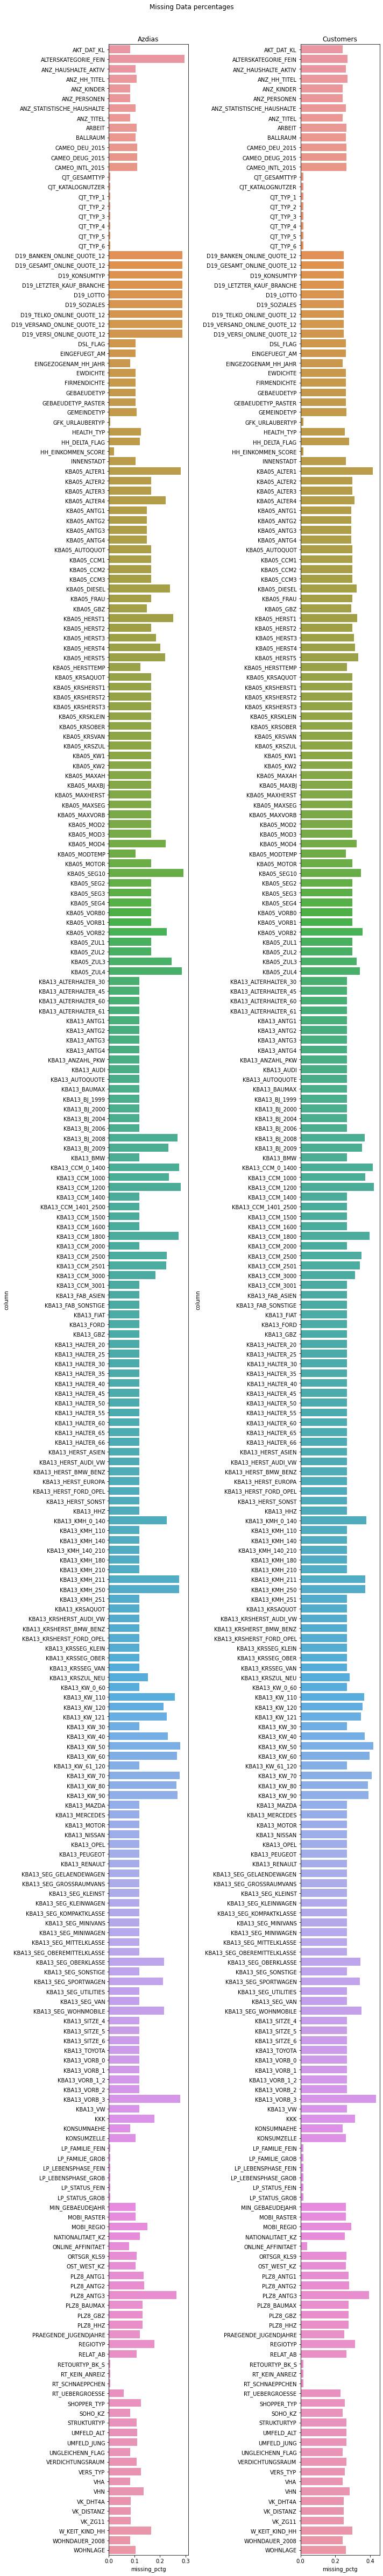

In [46]:
plot_missing_percentage(azdias, customers)

#### Remove rows with a high percentage of Null values

In [47]:
def get_missing_rows(data, threshold=50, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start labelling rows as missing')
    mask = _get_missing_count_row(data) > threshold 
    logger.debug('{} rows labelled as missing'.format(sum(mask)))
    
    logger.info('End labelling rows as missing in {} seconds'.format(timer.total()))
    return ~mask
    

def _get_missing_count_row(data):
    count_missing = data.isna().sum(axis=1)
    
    return count_missing


In [48]:
# missing rows in AZDIAS
rows_to_remove_azdias = get_missing_rows(azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:30:48 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:30:49 - DEBUG: 150501 rows labelled as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:30:49 - INFO: End labelling rows as missing in 1.39469 seconds


In [49]:
# missing rows in CUSTOMERS
rows_to_remove_customers = get_missing_rows(customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:30:49 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:30:50 - DEBUG: 57000 rows labelled as missing
UDACITY ARVATO PROJECT: 06/05/2021 20:30:50 - INFO: End labelling rows as missing in 0.32979 seconds


In [50]:
def drop_rows(data, mask, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing rows')
    data = data[mask]
    data = data.reset_index(drop=True)
    logger.debug('Removed {} rows'.format(len(data) - sum(mask)))
    
    logger.info('End removing rows in {} seconds'.format(timer.total()))
    return data


In [53]:
azdias = drop_rows(azdias, rows_to_remove_azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:31:58 - INFO: Start removing rows


MemoryError: Unable to allocate 1.39 GiB for an array with shape (252, 740720) and data type float64

In [54]:
customers = drop_rows(customers, rows_to_remove_customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 20:32:10 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 06/05/2021 20:32:12 - DEBUG: Removed 0 rows
UDACITY ARVATO PROJECT: 06/05/2021 20:32:12 - INFO: End removing rows in 2.04427 seconds


#### Classify columns into Numerical or Categorical

#### Transforming Categorical columns into Numerical columns

#### Check ID columns

#### Imputing missing values

### 0.5. Feature Scaling

### 0.6. Build a Function

Build a function that encompasses the stages of **Preprocessing**, **Univariate Analysis** and **Feature Scaling** optionally, in order to apply the same data cleaning process to all datasets used in this project.

#### Check Preprocessing and Univariate Analysis functions

#### Save datasets after Preprocessing and Univariate Analysis steps

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Load clean datasets

#### Scaling data

### 1.1. Principal Component Analysis

#### 1.1.1. Interpreting PCA components

### 1.2. K-Means Clustering

After having reduced the demographic dataset to principal components, we will use a K-Means model to segment the population.

#### 1.2.1. Select optimal K value with AZDIAS_PCA data

##### Choosing Number of Clusters

#### 1.2.2. Fit K-Means object with optimal K and AZDIAS PCA data

#### 1.2.3. Get AZDIAS PCA and CUSTOMERS PCA Clusters

##### AZDIAS Clusters

##### CUSTOMERS Clusters

##### Check results

#### 1.2.4. Get ratio between customers and general population for each Cluster

#### 1.2.5. Analyze Feature Weights in Clusters with highest percentage of customers

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

#### Check if target column is in dataset

#### Check number of events / no events

### 2.1. Selecting the evaluation metric

### 2.2. Apply Preprocessing and Univariate Analysis steps

#### 2.2.1. Split data for validation and train

### 2.3. Set a benchmark

### 2.4. Evaluate different binary classification estimators

### 2.5. Select the best binary classification estimator

#### 2.5.1. Give the best results after hyperparameter tunning

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
# mailout_test = pd.read_csv(r'./datasets/mailout_test.csv', index_col='Unnamed: 0')